# **Hypothesis Testing With Insurance Data**

_John Andrew Dixon_

---

##### **Imports**

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd

##### **Data Load**

In [51]:
# Remote URL to data
url = "https://docs.google.com/spreadsheets/d/e/2PACX-1vQ62VropqXZ6k0RwX0ErcJ-vwnCzfq2dD_vDiUEmaOyE4Xx8SW7dDkPoFa_LCH4zBsfrW6uinsvmgr_/pub?output=csv"
# Load the data
df = pd.read_csv(url)
# Verify
df.sample(5)

,age,sex,bmi,children,smoker,region,charges
897,19,male,25.555,1,no,northwest,2221.56445
1192,58,female,32.395,1,no,northeast,13019.16105
686,42,male,26.125,2,no,northeast,7729.64575
622,49,female,21.300,1,no,southwest,9182.17000
12,23,male,34.400,0,no,southwest,1826.84300


---

## **Test 1: Do smokers have higher insurance charges than non-smokers?**

#### **_Hypotheses_**

> **Null Hypothesis:** There is no significant difference between insurance charges of non-smokers and insurance charges of smokers. 

> **Alt. Hypothesis:** There is a significant difference between insurance charges of non-smokers and insurance charges of smokers, namely, that smokers have higher insurance charges than non-smokers.

#### **_Test Choice_**

> There are two groups/samples we are comparing (smokers v. non-smokers). For each, we're comparing numerical data (amount charged). So, we will run a **Independent/2-Sample T-Test**.

> For this test I'll use an alpha value of 0.05. It also has the following assumptions:
> 1. No significant outliers
> 2. Normality (or n > 15)
> 3. Equal variances

#### **_Checking Assumptions_**

##### Check and remove outliers

In [52]:
# Get only smokers
smokers = df.loc[df["smoker"] == "yes", :]
# Get non-smokers
non_smokers = df.loc[df["smoker"] == "no", :]

In [53]:
# Reveal potential outliers
smokers_zscores = stats.zscore(smokers["charges"])
smokers_outliers = abs(smokers_zscores) > 3
print(f"There are {np.sum(smokers_outliers)} outliers for smokers")

There are 0 outliers for smokers


In [54]:
# Reveal potential outliers
non_smokers_zscores = stats.zscore(non_smokers["charges"])
non_smokers_outliers = abs(non_smokers_zscores) > 3
print(f"There are {np.sum(non_smokers_outliers)} outliers for non-smokers")

There are 24 outliers for non-smokers


In [55]:
# Remove non-smoker outliers
non_smokers = non_smokers.loc[~non_smokers_outliers, :]

##### Check for normality

> _Null hypothesis for normality test: the distribution is normal_

In [56]:
result_smokers = stats.normaltest(smokers["charges"])
result_smokers

NormaltestResult(statistic=61.03941356533816, pvalue=5.564930630036463e-14)

In [57]:
result_non_smokers = stats.normaltest(non_smokers["charges"])
result_non_smokers

NormaltestResult(statistic=163.80367047789198, pvalue=2.6945416315543976e-36)

> The p-values for both groups are well below the function's alpha of 0.05. So, we reject the null hypothesis and conclude that the data is not normally distributed. Now, to verify the size of each sample to see if it is sufficiently large to use without satisfying the assumption:

In [58]:
print("Non-smokers sample size:", len(non_smokers))
print("Smokers sample size:", len(smokers))

Non-smokers sample size: 1040
Smokers sample size: 274


> For this type of test, each group must have n > 15 and each does. So, we can safely ignore the assumption of normality.

##### Check for equal variance

> _Null hypothesis for equal variance test: the groups have equal variances._

In [59]:
result = stats.levene(smokers["charges"], non_smokers["charges"])
result

LeveneResult(statistic=520.7468821724297, pvalue=2.4247238784347824e-97)

> Since the p-value is significantly less than 0.05 we can reject the null hypothesis of the test and conclude that the groups do not have equal variances.  So, when the test is run using `stats.ttest_ind`, the `equal_var` parameter will be set to `False` to run a test to account for the unequal variances.

#### **_Statistical Test_**

In [60]:
result = stats.ttest_ind(smokers["charges"], non_smokers["charges"], equal_var=False)
result

Ttest_indResult(statistic=33.732305987092516, pvalue=2.575322662587431e-104)

> Our p-value is less than our alpha (0.05), so we reject the null hypothesis and conclude that there is a significant difference between insurance charges of non-smokers and insurance charges of smokers. However, this does not confirm whether it is smokers or non-smokers who get charged more.

#### **_Visual Results_**

> The result of our test says that there is a significant difference in charges between smokers and non-smokers. A visual can help clear up which gets charged more:

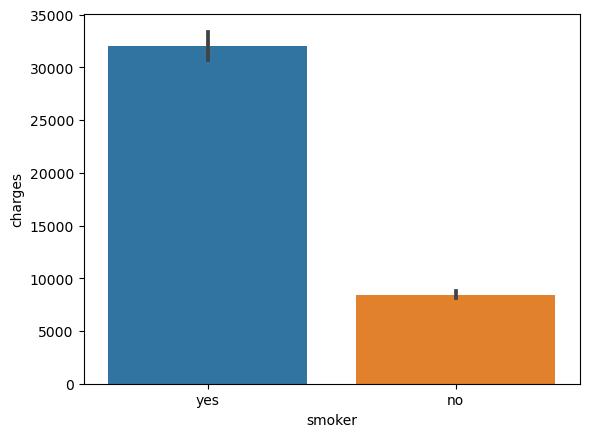

In [61]:
sns.barplot(data=df, x="smoker", y="charges");

> As shown above (via the visual _and_ the previous test), the final answer to the question is yes, smokers have higher insurance charges than non-smokers.

## **Test 2: Are men more likely to smoke than women?**

#### **_Hypotheses_**

> **Null Hypothesis:** There is no significant relationship between sex and smoker status.

> **Alt. Hypothesis:** There is a significant relationship between sex and smoker status, namely, that men smoke more than women.

#### **_Test Choice_**

> There are two groups/samples we are comparing (men v. women). For each, we're comparing binary categorical target data (smoker v. non-smoker). So, I perceive we will run a **Chi-Square Test**.

> For this test I'll use an alpha value of 0.05. It also has the following assumptions:
> 1. There are two categorical variables (ordinal or nominal)
> 2. The outcomes are independent

#### **_Checking Assumptions_**

> The two variables (male or female) we are considering are categorical in nature, namely they are nominal. Thus, the first assumption is met.

> The two variables we are considering are have outcomes independent of one another. Whether a male is a smoker is not affected by whether a female is a smoker. Thus, the second assumption is met.

#### **_Statistical Test_**

In [62]:
# Obtain the contingency table
cross_tab = pd.crosstab(df["sex"], df["smoker"])
cross_tab

smoker,no,yes
sex,,
female,547,115
male,517,159


In [63]:
# Perform the test
result = stats.chi2_contingency(cross_tab)
_, p, _, _ = result

In [64]:
print(p)
p < 0.05

0.006548143503580696


True

> Our p-value is less than our alpha (0.05), so we reject the null hypothesis and conclude that there is a significant relationship between sex and smoker status, though we don't know which smokes more yet.

#### **_Visual Results_**

> The result of our test says that there is a relationship between sex and smoker status. A visual can help us better understand which sex smokes more:

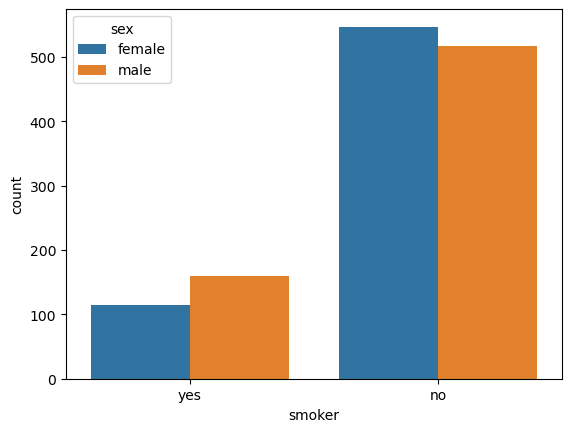

In [65]:
sns.countplot(data=df, x="smoker", hue="sex");

> The visual shows that, among smokers, there are more men than women. Likewise, among non-smokers there are more women than men. These facts coupled with the result of our test highlight our final result: men do smoke more than women.

## **Test 3: Do different regions have different charges, on average?**

#### **_Hypotheses_**

> **Null Hypothesis:** On average, there is no significant difference in charges across regions.

> **Alt. Hypothesis:** On average, there is a significant difference in charges across regions.

#### **_Test Choice_**

> There are multiple groups/samples we are comparing (many regions). For each, we're comparing numerical data (amount charged). So, we will run a **One-Way ANOVA Test** and then a **Tukey Test**.

> For this test I'll use an alpha value of 0.05. It also has the following assumptions:
> 1. No significant outliers
> 2. Normality (or for 2-9 groups, n > 15)
> 3. Equal variances

#### **_Checking Assumptions_**

##### Check and remove outliers:

In [66]:
# Define a dictionary with the regions
regions = {}

# Store the charge data from each region as a value and the region as the key
for region in df["region"].unique():
    data = df.loc[df["region"] == region, "charges"]
    regions[region] = data

# Show the keys
regions.keys()

dict_keys(['southwest', 'southeast', 'northwest', 'northeast'])

In [67]:
# Check for outliers
for region in regions.keys():
    # Get the zscores for the specific region
    zscores = stats.zscore(regions[region])
    # Get the outliers for the region
    outliers = abs(zscores) > 3
    # Display how much outliers there are
    print(f"There are {outliers.sum()} outliers for the {region} region")

    # If there are outliers, remove them.
    if outliers.sum():
        print("Removing them.")
        regions[region] = regions[region].loc[~outliers]

There are 8 outliers for the southwest region
Removing them.
There are 2 outliers for the southeast region
Removing them.
There are 7 outliers for the northwest region
Removing them.
There are 4 outliers for the northeast region
Removing them.


##### Check for normality

> _Null hypothesis for normality test: the distribution is normal._

In [68]:
# Create a dictionary for region normal test results
region_norm_results = {}

# Iterate through all the regions
for key, values in regions.items():
    stat, p = stats.normaltest(values)
    region_norm_results[key] = {
        "n": len(values),
        "p": p,
        "test stat": stat
    }

# Make into a DataFrame for easy viewing
region_norm_results_df = pd.DataFrame(region_norm_results).T
region_norm_results_df

,n,p,test stat
southwest,317.0,7.728611e-22,97.223886
southeast,362.0,1.936990e-13,58.544942
northwest,318.0,2.940543e-19,85.341045
northeast,320.0,3.557877e-17,75.749565


> All the p-values are well under the function's alpha (0.05), so for each region we reject the null hypothesis and conclude that none of the regions have a normal distribution. However, each region has well over the required amount of samples (for One-way ANOVA tests with 2-9 groups, n > 15) to safely ignore the normality assumption. So, we will move on.

##### Check for equal variance

> _Null hypothesis for equal variance test: the groups have equal variances._

In [69]:
stats.levene(*regions.values())

LeveneResult(statistic=9.518349004554441, pvalue=3.2035503711783993e-06)

> The p-value is well under our alpha (0.05), leading us to reject the null hypothesis and conclude that the groups do not have equal variances. Thus, the non-parametric Kruskal-Wallis test must be used. 

#### **_Statistical Test_**

In [70]:
stats.kruskal(*regions.values())

KruskalResult(statistic=6.914045702545643, pvalue=0.07468847911322242)

> The non-parametric Kruskal-Wallis test returned a p-value that is greater than our alpha (0.05). Thus, there is a significant difference in regional charges, thougn we don't know which ones yet. Now, using the Tukey test, I'll see which regions show the difference.

> _Note: I was told we are able to use the Tukey test after using a non-parametric test._

In [71]:
tukeys_results = pairwise_tukeyhsd(df["charges"], df["region"])
tukeys_results.summary()
> According to the Tukey Test, the only regions that have significant differences in charges between one another are the southeast and southwest region. All other regions do not have significant differences in charges between each other.

group1,group2,meandiff,p-adj,lower,upper,reject
northeast,northwest,-988.8091,0.7245,-3428.9343,1451.3161,False
northeast,southeast,1329.0269,0.4745,-1044.9417,3702.9955,False
northeast,southwest,-1059.4471,0.6792,-3499.5723,1380.6781,False
northwest,southeast,2317.8361,0.0583,-54.1994,4689.8716,False
northwest,southwest,-70.638,0.9999,-2508.8826,2367.6066,False
southeast,southwest,-2388.4741,0.0477,-4760.5096,-16.4386,True


#### **_Visual Results_**

> With a visual, we can identify the exact nature of the differences in charges between the southeast and southwest regions:

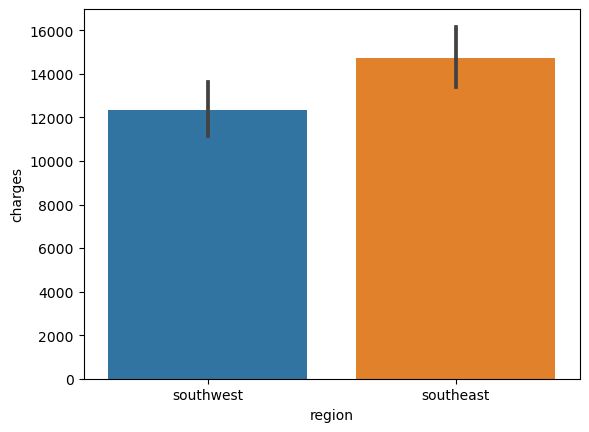

In [77]:
sns.barplot(data=df.loc[(df["region"] == "southwest") | (df["region"] == "southeast"), :], x="region", y="charges");

> According to the final results of our test and the visual above, the southeast region is charged more than the southwest region.